In [575]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn import datasets


In [576]:
#df= pd.read_csv('anonymized-curriculum-access.csv')
#df=pd.DataFrame(df)

In [577]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

#### Wrangle Data
#### Acquire

In [578]:
#colnames=[{0:"date", 1:"time", 2:"page", 3:"num1", 4:"num2", 5:"ip"}]
df_orig = pd.read_csv('anonymized-curriculum-access.csv',
                 header=None,
                 sep= " "
)



df = df_orig
df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [596]:
df = df.rename(columns={0:"date", 1:"time", 2:"page", 3:"id", 4:"group", 5:"ip"})

df.describe()

,id,group
count,386922.000000,386922.000000
mean,263.427743,24.668703
std,145.012240,9.762811
min,1.000000,0.000000
25%,153.000000,23.000000
50%,277.000000,26.000000
75%,383.000000,31.000000
max,514.000000,51.000000


In [580]:
df=pd.DataFrame(df)

df.fillna(0, inplace = True)
df.isnull().sum()

date     0
time     0
page     0
id       0
group    0
ip       0
dtype: int64

In [581]:
df.set_index(df['date'])
df.describe()

,id,group
count,399195.000000,399195.000000
mean,268.794667,25.108967
std,147.587312,10.135326
min,1.000000,0.000000
25%,157.000000,23.000000
50%,288.000000,26.000000
75%,392.000000,31.000000
max,543.000000,52.000000


In [582]:
df.date = pd.to_datetime(df.date)
df = df.set_index("date")
df = df.drop(pd.date_range('2019-11-04', '2019-11-19'))


#### Prep and clean

In [583]:
#Clean up nulls
df.isnull().sum()

time     0
page     0
id       0
group    0
ip       0
dtype: int64

In [584]:
df.id.describe()

count    386922.000000
mean        263.427743
std         145.012240
min           1.000000
25%         153.000000
50%         277.000000
75%         383.000000
max         514.000000
Name: id, dtype: float64

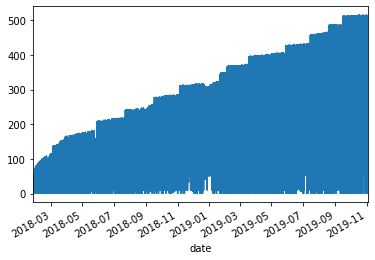

In [585]:
df.id.plot()
plt.show()

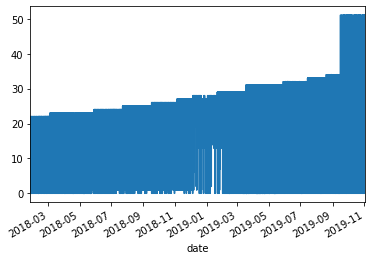

In [586]:
df.group.plot()
plt.show()

### working on id(?) column

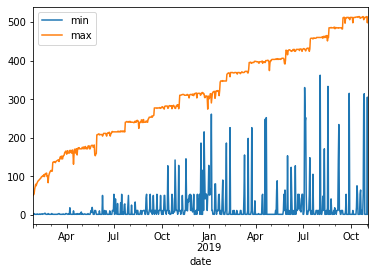

In [587]:
df.id.resample("D").min().plot(label="min")
df.id.resample("D").max().plot(label="max")
plt.legend()
plt.show()

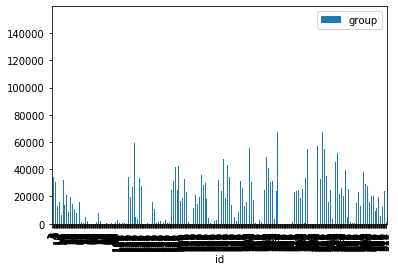

In [588]:
df.groupby('id').sum().plot(kind='bar');

##### column2

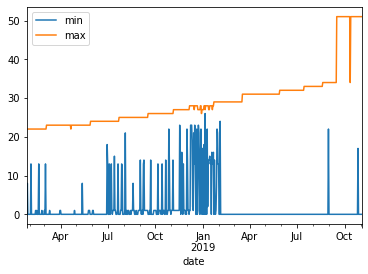

In [589]:
df.group.resample("D").min().plot(label="min")
df.group.resample("D").max().plot(label="max")
plt.legend()
plt.show()

In [640]:
#Value counts in each group
groupb= df.group.value_counts()
groupb

29.0    35535
24.0    35010
33.0    31799
22.0    28875
23.0    28028
26.0    26561
0.0     26542
32.0    26478
25.0    25226
31.0    22560
27.0    20176
28.0    19565
34.0    13709
14.0     8930
1.0      8877
51.0     8671
21.0     7147
17.0     3712
13.0     2585
8.0      1671
18.0     1602
19.0     1142
16.0      740
15.0      691
7.0       442
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
Name: group, dtype: int64

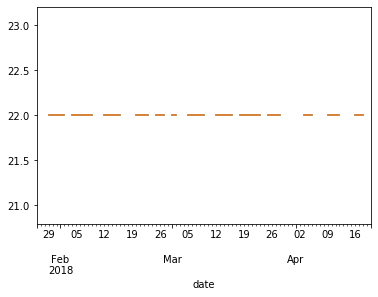

In [638]:
person22.group.resample("D").min().plot(label="min")
person22.group.resample("D").max().plot(label="max")

In [625]:
group21= df.where(df.group == 21).dropna()
group22=df.where(df.group==22).dropna()
group29=df.where(df.group==29).dropna()
group0=df.where(df.group==0.0).dropna()
group4=df.where(df.group==4).dropna()
group14=df.where(df.group==4).dropna()


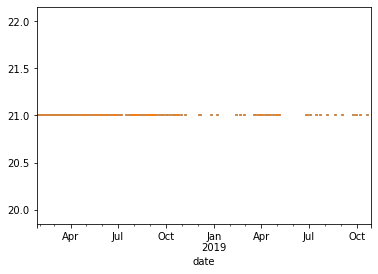

In [558]:
group21.group.resample("D").min().plot(label="min")
group21.group.resample("D").max().plot(label="max")

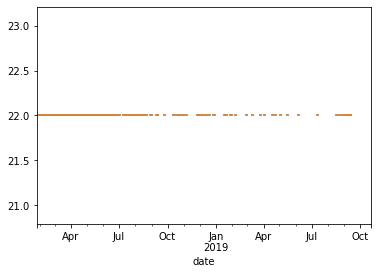

In [608]:
group22.group.resample("D").min().plot(label="min")
group22.group.resample("D").max().plot(label="max")

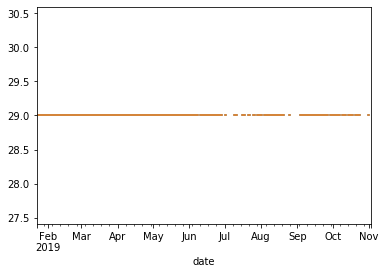

In [612]:
group29.group.resample("D").min().plot(label="min")
group29.group.resample("D").max().plot(label="max")

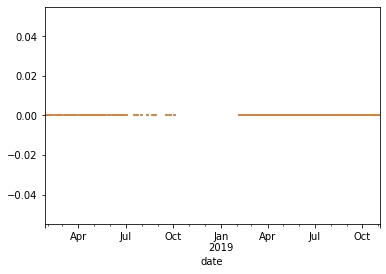

In [621]:
group0.group.resample("D").min().plot(label="min")
group0.group.resample("D").max().plot(label="max")

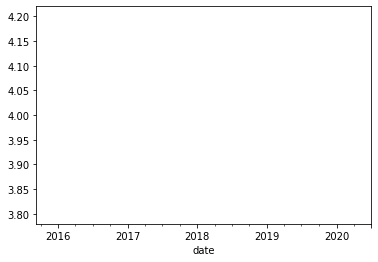

In [623]:
group14.group.resample("D").min().plot(label="min")
group14.group.resample("D").max().plot(label="max")

In [610]:
#Value counts in each group
groupb= df.group.value_counts()
groupb

29.0    35535
24.0    35010
33.0    31799
22.0    28875
23.0    28028
26.0    26561
0.0     26542
32.0    26478
25.0    25226
31.0    22560
27.0    20176
28.0    19565
34.0    13709
14.0     8930
1.0      8877
51.0     8671
21.0     7147
17.0     3712
13.0     2585
8.0      1671
18.0     1602
19.0     1142
16.0      740
15.0      691
7.0       442
12.0      270
11.0      204
2.0        93
6.0        72
9.0         5
4.0         4
Name: group, dtype: int64

In [641]:
df = df[["id", "group"]]

In [642]:
np_array = df.values.astype("float32", copy = False)

SyntaxError: invalid syntax (<ipython-input-643-b8e2ceec31f4>, line 1)

#### Split into train/test

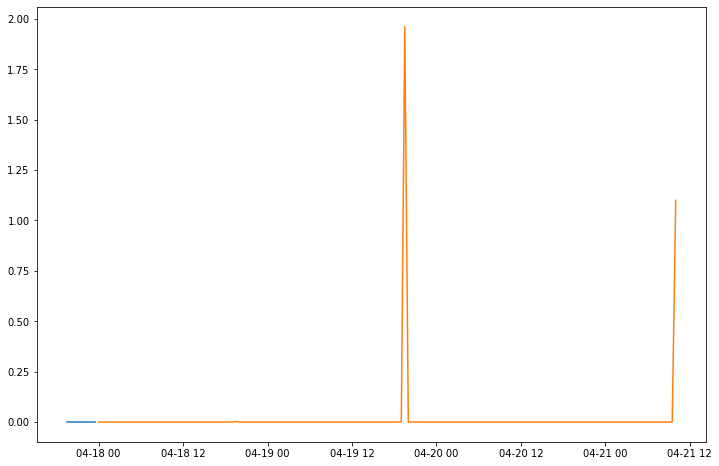

In [112]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

#### SMA - Simple Moving Average

In [113]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

#### Plot the 2 window sizes for the SMA:

Text(0, 0.5, 'Size (MB)')

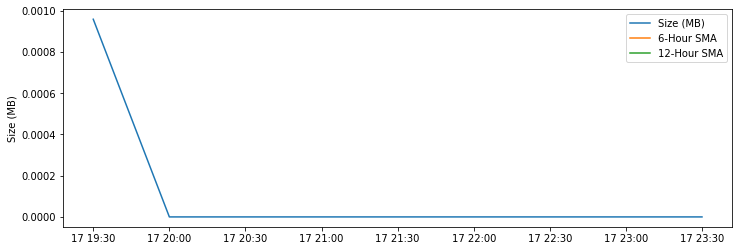

In [114]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

#### Exponential Moving Average

In [115]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=12, adjust=False).mean()
ema_long[0:3]

2019-04-17 19:30:00+00:00    0.000958
2019-04-17 20:00:00+00:00    0.000811
2019-04-17 20:30:00+00:00    0.000686
Freq: 30T, Name: size_mb, dtype: float64

In [116]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

#### Compare SMA with EMA:

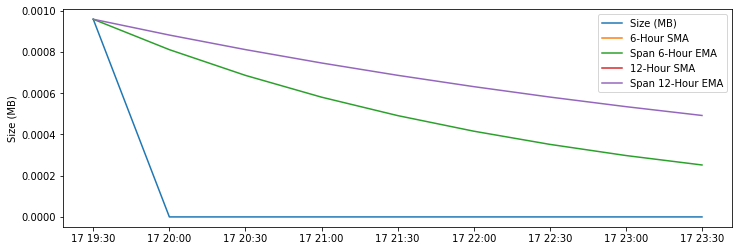

In [117]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test))

#### Forecast using the EMA

In [118]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

#### Compute the '%b' for each record:

In [119]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

#### Extract the anomalies:

In [120]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-18 19:30:00+00:00,0.002441,0.000492,0.001950,2.691088
2019-04-19 19:30:00+00:00,1.961066,0.000492,1.960574,2204.017316
2019-04-21 10:00:00+00:00,1.099591,0.000492,1.099099,1235.793360


#### Plot

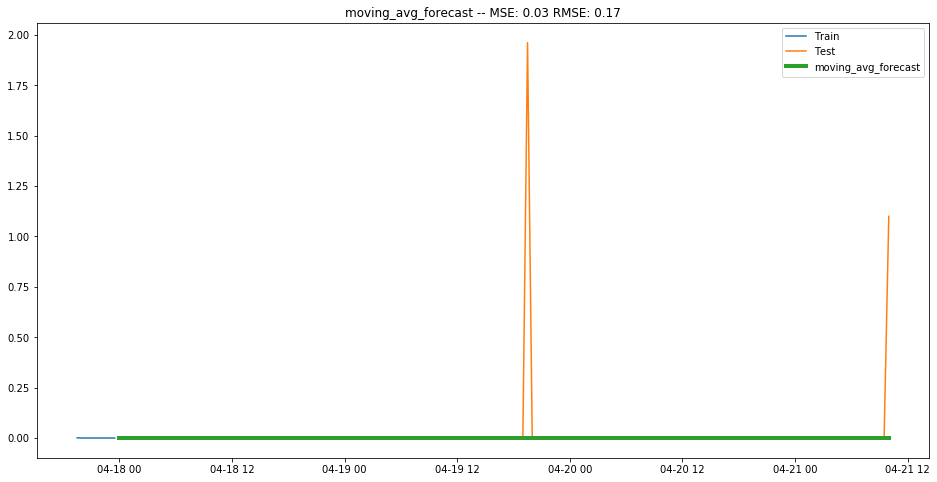

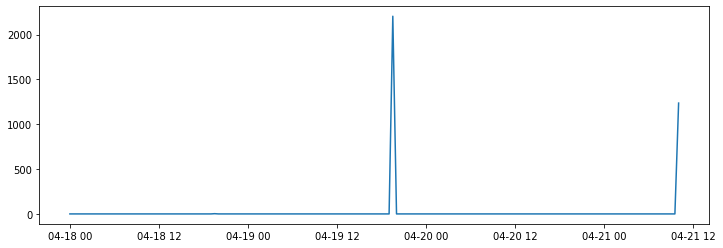

In [121]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)